In [169]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from torchvision import datasets, transforms
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages
logging.basicConfig(level=logging.DEBUG, format='%(levelname)s: %(message)s')

# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of src.dyadictree failed: Traceback (most recent call last):
  File "/scratch/f006pq6/softwares/miniconda3/envs/gmra/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/scratch/f006pq6/softwares/miniconda3/envs/gmra/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/scratch/f006pq6/softwares/miniconda3/envs/gmra/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/scratch/f006pq6/projects/gmra-python/experiments/mnist

In [170]:
def load_dataset(flatten=False):
    num_points = 100
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    cifar10_train = datasets.MNIST(root='../../datasets', train=True, download=True, transform=transform)
    X = np.stack([np.array(img[0].numpy()) for img in cifar10_train][:num_points])  # shape: (1000, 3, 32, 32)

    original_shape = X.shape
    if flatten:
        X = X.reshape(X.shape[0], -1)
    # print(X.shape)
    return X, original_shape    

X, original_shape = load_dataset(flatten=True)
p_n_points = X.shape[0]
print("X shape: %s" % str(X.shape))
print(p_n_points)


X shape: (100, 784)
100


In [171]:
print("Creating CoverTree...")
python_covertree =  CoverTree(X, euclidean, leafsize=1)
print("CoverTree creation completed.")

Creating CoverTree...
CoverTree creation completed.


In [172]:
# Create enhanced dyadic tree with wavelet functionality
# This will show debug logs during tree construction
print("Creating DyadicTree with wavelet functionality...")
print("This will show detailed debug information about tree construction:")
print("-" * 60)

from scipy.spatial.distance import euclidean
enhanced_tree = DyadicTree(python_covertree, X, 0, X.shape[-1], inverse=True,
                          thresholds=0.0) # inverse means data in (n,d) format

print("-" * 60)
print("DyadicTree creation completed.")

DEBUG: Building tree at level 1, node indices: [56 88 81 34 37 75  1 69 95 78 59  3 23 77 43 24 67 40 72 19 79 26 29 22
 61 33 42 96 99 57 53 15 91 71 87 89 98 44 49 74 50 48 10 12 32 90 39 36
 18  0 85 41 17 55 97 94 73 62 93 83 66 13  8 14 70  4  6 35 80 84 45 52
 54 27  7 38 16 51 21 63 25 46 65 11 28 60 68  9 92 58  2 64 30 31 82 76
 20  5 86 47]
DEBUG: Updated tree height to 2
DEBUG: Processing internal node at level 1 with 32 children
DEBUG: Created child 1/32 at level 1
DEBUG: Building tree at level 2, node indices: [56 88]
DEBUG: Updated tree height to 3
DEBUG: Processing internal node at level 2 with 2 children
DEBUG: Created child 1/2 at level 2
DEBUG: Building tree at level 3, node indices: [56]
DEBUG: Updated tree height to 4
DEBUG: Created leaf node at level 3 with indices: [56]
DEBUG: Created child 2/2 at level 2
DEBUG: Building tree at level 3, node indices: [88]
DEBUG: Created leaf node at level 3 with indices: [88]
DEBUG: Created child 2/32 at level 1
DEBUG: Building t

DEBUG: Created child 13/18 at level 2
DEBUG: Building tree at level 3, node indices: [33]
DEBUG: Created leaf node at level 3 with indices: [33]
DEBUG: Created child 14/18 at level 2
DEBUG: Building tree at level 3, node indices: [42]
DEBUG: Created leaf node at level 3 with indices: [42]
DEBUG: Created child 15/18 at level 2
DEBUG: Building tree at level 3, node indices: [96]
DEBUG: Created leaf node at level 3 with indices: [96]
DEBUG: Created child 16/18 at level 2
DEBUG: Building tree at level 3, node indices: [99]
DEBUG: Created leaf node at level 3 with indices: [99]
DEBUG: Created child 17/18 at level 2
DEBUG: Building tree at level 3, node indices: [57]
DEBUG: Created leaf node at level 3 with indices: [57]
DEBUG: Created child 18/18 at level 2
DEBUG: Building tree at level 3, node indices: [53]
DEBUG: Created leaf node at level 3 with indices: [53]
DEBUG: Created child 4/32 at level 1
DEBUG: Building tree at level 2, node indices: [15 91 71 87 89]
DEBUG: Processing internal no

Creating DyadicTree with wavelet functionality...
This will show detailed debug information about tree construction:
------------------------------------------------------------


DEBUG: Created leaf node at level 3 with indices: [48]
DEBUG: Created child 7/8 at level 2
DEBUG: Building tree at level 3, node indices: [10]
DEBUG: Created leaf node at level 3 with indices: [10]
DEBUG: Created child 8/8 at level 2
DEBUG: Building tree at level 3, node indices: [12]
DEBUG: Created leaf node at level 3 with indices: [12]
DEBUG: Created child 6/32 at level 1
DEBUG: Building tree at level 2, node indices: [32 90 39 36 18]
DEBUG: Processing internal node at level 2 with 5 children
DEBUG: Created child 1/5 at level 2
DEBUG: Building tree at level 3, node indices: [32]
DEBUG: Created leaf node at level 3 with indices: [32]
DEBUG: Created child 2/5 at level 2
DEBUG: Building tree at level 3, node indices: [90]
DEBUG: Created leaf node at level 3 with indices: [90]
DEBUG: Created child 3/5 at level 2
DEBUG: Building tree at level 3, node indices: [39]
DEBUG: Created leaf node at level 3 with indices: [39]
DEBUG: Created child 4/5 at level 2
DEBUG: Building tree at level 3, n

info: making wavelet tree


DEBUG: Node (j=0, k=0) basis shape: (100, 784), sigmas: 101
DEBUG: Processing level 1 with 32 children
DEBUG: Computing basis for node (j=1, k=0) with 2 points, is_leaf=False
DEBUG: Node (j=1, k=0) basis shape: (2, 784), sigmas: 3
DEBUG: Processing level 2 with 2 children
DEBUG: Computing basis for node (j=2, k=0) with 1 points, is_leaf=False
DEBUG: Node (j=2, k=0) basis shape: (0, 784), sigmas: 2
DEBUG: Processing level 3 with 1 children
DEBUG: Computing basis for node (j=3, k=0) with 1 points, is_leaf=True
DEBUG: Node (j=3, k=0) basis shape: (0, 784), sigmas: 2
DEBUG: Processing level 4 with 0 children
DEBUG: Computing basis for node (j=2, k=1) with 1 points, is_leaf=False
DEBUG: Node (j=2, k=1) basis shape: (0, 784), sigmas: 2
DEBUG: Processing level 3 with 1 children
DEBUG: Computing basis for node (j=3, k=1) with 1 points, is_leaf=True
DEBUG: Node (j=3, k=1) basis shape: (0, 784), sigmas: 2
DEBUG: Processing level 4 with 0 children
DEBUG: Computing basis for node (j=1, k=1) with 7

info: making wavelets
------------------------------------------------------------
DyadicTree creation completed.


In [173]:
# enhanced_tree.plot_tree()
# traverse dyadic tree, print all node's j and k

# print("Traversing DyadicTree to print all nodes' j and k values (checking for duplicates):")
# seen_jk = set()
# duplicates = []
# def traverse_tree(node, depth=0):
#     if node is None:
#         return
#     jk = (node.node_j, node.node_k)
#     if jk in seen_jk:
#         duplicates.append(jk)
#     else:
#         seen_jk.add(jk)
#     print(f"{' ' * depth * 2}Node at depth {depth}: j={node.node_j}, k={node.node_k}")
#     for child in node.children:
#         traverse_tree(child, depth + 1)
# traverse_tree(enhanced_tree.root)
# if duplicates:
#     print(f"Duplicate (j, k) pairs found: {duplicates}")
# else:
#     print("No duplicate (j, k) pairs found.")


In [174]:
# add some small noise to X

# X += np.random.normal(0, 0.01, X.shape)*10
print("Computing forward GMRA wavelet transform...")
gmra_q_coeff, leaves_j_k  = enhanced_tree.fgwt(X)
print("Forward transform completed.")

DEBUG: Starting forward GMRA wavelet transform for 100 data points


DEBUG: Found 100 leaf nodes, levels range: j=2 to j=5
DEBUG: Processing point 1/100, leaf at (j=2, k=45)
DEBUG: Point 0: path length 3, leaf->root traversal
DEBUG: Point 0: processed node at (j=1, k=6), qjx shape: (0, 1)
DEBUG: Point 0: completed, total coefficients at 3 levels
DEBUG: Point 1: path length 4, leaf->root traversal
DEBUG: Point 1: processed node at (j=2, k=6), qjx shape: (0, 1)
DEBUG: Point 1: processed node at (j=1, k=1), qjx shape: (7, 1)
DEBUG: Point 1: completed, total coefficients at 4 levels
DEBUG: Point 2: path length 4, leaf->root traversal
DEBUG: Point 2: processed node at (j=2, k=85), qjx shape: (0, 1)
DEBUG: Point 2: processed node at (j=1, k=22), qjx shape: (3, 1)
DEBUG: Point 2: completed, total coefficients at 4 levels
DEBUG: Point 3: path length 6, leaf->root traversal
DEBUG: Point 3: processed node at (j=4, k=1), qjx shape: (0, 1)
DEBUG: Point 3: processed node at (j=3, k=11), qjx shape: (1, 1)
DEBUG: Point 3: processed node at (j=2, k=10), qjx shape: (4, 

Computing forward GMRA wavelet transform...


DEBUG: Point 21: path length 4, leaf->root traversal
DEBUG: Point 21: processed node at (j=2, k=73), qjx shape: (0, 1)
DEBUG: Point 21: processed node at (j=1, k=14), qjx shape: (3, 1)
DEBUG: Point 21: completed, total coefficients at 4 levels
DEBUG: Point 22: path length 4, leaf->root traversal
DEBUG: Point 22: processed node at (j=2, k=19), qjx shape: (0, 1)
DEBUG: Point 22: processed node at (j=1, k=2), qjx shape: (21, 1)
DEBUG: Point 22: completed, total coefficients at 4 levels
DEBUG: Point 23: path length 6, leaf->root traversal
DEBUG: Point 23: processed node at (j=4, k=2), qjx shape: (0, 1)
DEBUG: Point 23: processed node at (j=3, k=11), qjx shape: (1, 1)
DEBUG: Point 23: processed node at (j=2, k=10), qjx shape: (4, 1)
DEBUG: Point 23: processed node at (j=1, k=2), qjx shape: (21, 1)
DEBUG: Point 23: completed, total coefficients at 6 levels
DEBUG: Point 24: path length 4, leaf->root traversal
DEBUG: Point 24: processed node at (j=2, k=12), qjx shape: (0, 1)
DEBUG: Point 24: p

Forward transform completed.


In [175]:
# Show some tree statistics from the debug information
print(f"Tree height: {enhanced_tree.height}")
print(f"Number of nodes in j_k_to_node mapping: {len(enhanced_tree.j_k_to_node)}")
print(f"Root node has {len(enhanced_tree.root.children)} children")
print(f"Root node indices: {enhanced_tree.root.idxs}")

# Show nodes at each level
for level in range(enhanced_tree.height):
    nodes_at_level = [node for (j, k), node in enhanced_tree.j_k_to_node.items() if j == level]
    print(f"Level {level}: {len(nodes_at_level)} nodes")

Tree height: 6
Number of nodes in j_k_to_node mapping: 220
Root node has 32 children
Root node indices: [56 88 81 34 37 75  1 69 95 78 59  3 23 77 43 24 67 40 72 19 79 26 29 22
 61 33 42 96 99 57 53 15 91 71 87 89 98 44 49 74 50 48 10 12 32 90 39 36
 18  0 85 41 17 55 97 94 73 62 93 83 66 13  8 14 70  4  6 35 80 84 45 52
 54 27  7 38 16 51 21 63 25 46 65 11 28 60 68  9 92 58  2 64 30 31 82 76
 20  5 86 47]
Level 0: 1 nodes
Level 1: 32 nodes
Level 2: 95 nodes
Level 3: 82 nodes
Level 4: 8 nodes
Level 5: 2 nodes


In [176]:
# print(mydiadic_tree.height)# mydiadic_tree.grow_tree()

In [177]:
# Now use mydiadic_tree.j_k_to_node instead of wavelet_tree.j_k_to_wavelet_node

In [178]:
# mydiadic_tree.plot_tree()

In [179]:
# mydiadic_tree.grow_tree()


In [180]:
# mydiadic_tree.grow_tree()

In [181]:
# mydiadic_tree.plot_tree()

In [182]:
print("Computing inverse GMRA wavelet transform...")
x_recon = enhanced_tree.igwt(gmra_q_coeff, leaves_j_k, X.shape)
print("Inverse transform completed.")

DEBUG: Starting inverse GMRA wavelet transform for 100 data points
DEBUG: Reconstruction target shape: (100, 784)
DEBUG: Reconstructing point 1/100
DEBUG: Point 0: starting from leaf (j=2, k=45), 3 coefficient levels
DEBUG: Point 0: leaf reconstruction, Qjx shape: (784, 1)
DEBUG: Point 0: intermediate level (j=1, k=6), Qjx shape: (784, 1)
DEBUG: Point 0: root level reconstruction, final Qjx shape: (784, 1)
DEBUG: Point 0: reconstruction norm: 9.557696
DEBUG: Point 1: starting from leaf (j=3, k=6), 4 coefficient levels
DEBUG: Point 1: leaf reconstruction, Qjx shape: (784, 1)


DEBUG: Point 1: intermediate level (j=2, k=6), Qjx shape: (784, 1)
DEBUG: Point 1: intermediate level (j=1, k=1), Qjx shape: (784, 1)
DEBUG: Point 1: root level reconstruction, final Qjx shape: (784, 1)
DEBUG: Point 2: starting from leaf (j=3, k=81), 4 coefficient levels
DEBUG: Point 2: leaf reconstruction, Qjx shape: (784, 1)
DEBUG: Point 2: intermediate level (j=2, k=85), Qjx shape: (784, 1)
DEBUG: Point 2: intermediate level (j=1, k=22), Qjx shape: (784, 1)
DEBUG: Point 2: root level reconstruction, final Qjx shape: (784, 1)
DEBUG: Point 3: starting from leaf (j=5, k=0), 6 coefficient levels
DEBUG: Point 3: leaf reconstruction, Qjx shape: (784, 1)
DEBUG: Point 3: intermediate level (j=4, k=1), Qjx shape: (784, 1)
DEBUG: Point 3: intermediate level (j=3, k=11), Qjx shape: (784, 1)
DEBUG: Point 3: intermediate level (j=2, k=10), Qjx shape: (784, 1)
DEBUG: Point 3: intermediate level (j=1, k=2), Qjx shape: (784, 1)
DEBUG: Point 3: root level reconstruction, final Qjx shape: (784, 1)


Computing inverse GMRA wavelet transform...


DEBUG: Point 4: starting from leaf (j=3, k=63), 4 coefficient levels
DEBUG: Point 4: leaf reconstruction, Qjx shape: (784, 1)
DEBUG: Point 4: intermediate level (j=2, k=60), Qjx shape: (784, 1)
DEBUG: Point 4: intermediate level (j=1, k=9), Qjx shape: (784, 1)
DEBUG: Point 4: root level reconstruction, final Qjx shape: (784, 1)
DEBUG: Point 5: starting from leaf (j=2, k=92), 3 coefficient levels
DEBUG: Point 5: leaf reconstruction, Qjx shape: (784, 1)
DEBUG: Point 5: intermediate level (j=1, k=29), Qjx shape: (784, 1)
DEBUG: Point 5: root level reconstruction, final Qjx shape: (784, 1)
DEBUG: Point 6: starting from leaf (j=3, k=64), 4 coefficient levels
DEBUG: Point 6: leaf reconstruction, Qjx shape: (784, 1)
DEBUG: Point 6: intermediate level (j=2, k=61), Qjx shape: (784, 1)
DEBUG: Point 6: intermediate level (j=1, k=9), Qjx shape: (784, 1)
DEBUG: Point 6: root level reconstruction, final Qjx shape: (784, 1)
DEBUG: Point 7: starting from leaf (j=3, k=71), 4 coefficient levels
DEBUG: P

Inverse transform completed.


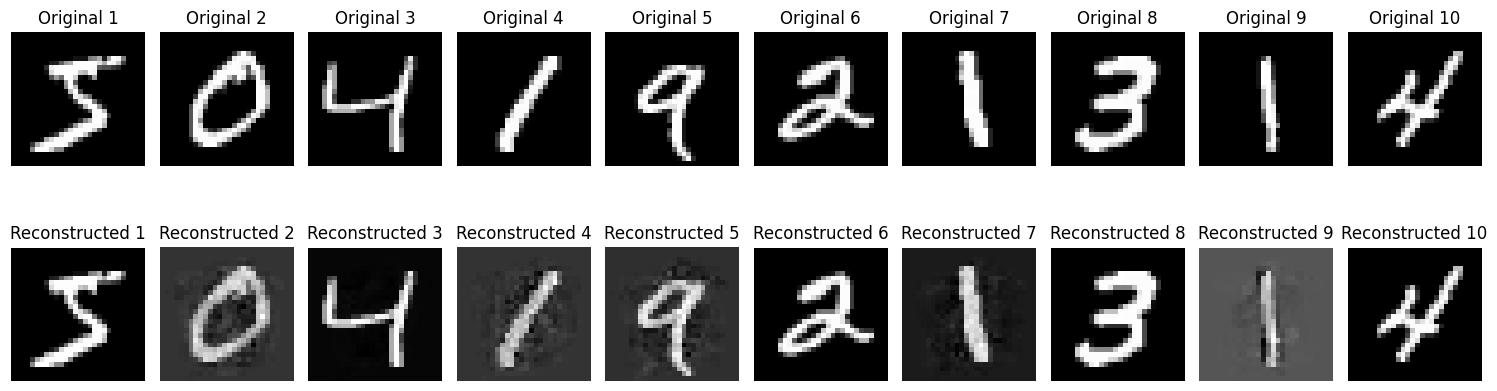

In [183]:
# plot x & x_recon for mnist in 2 row, take 5 images, remember to reshape to image

n_images = 10
fig, axs = plt.subplots(2, n_images, figsize=(15, 5))
for i in range(n_images):
    axs[0, i].imshow(X[i].reshape(original_shape[2:]), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Original {i+1}')

    axs[1, i].imshow(x_recon[i].reshape(original_shape[2:]), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Reconstructed {i+1}')
plt.tight_layout()
plt.show()

In [184]:
# reconstruction error:
reconstruction_error = np.linalg.norm(X - x_recon, axis=1)
print("Reconstruction error (first 10):", reconstruction_error[:10])
print("Mean reconstruction error:", np.mean(reconstruction_error))

# snr signal to noise ratio
snr = 10 * np.log10(np.sum(X**2) / np.sum((X - x_recon)**2))
print("SNR:", snr)

Reconstruction error (first 10): [1.18851681e-06 2.02248851e+00 2.02640525e-01 2.28307024e+00
 1.78221281e+00 1.15872729e-06 9.47888427e-01 1.26834801e-02
 3.31711092e+00 1.21462139e-06]
Mean reconstruction error: 1.144784328054293
SNR: 16.096032317776945
